In [4]:
import yfinance as yf

# Search for a company by name
search_result = yf.Ticker("HDFCBANK.NS")
print(search_result.info)


{'address1': 'HDFC Bank House', 'address2': 'Shiv Sagar Estate Dr Annie Besant Road Worli', 'city': 'Mumbai', 'zip': '400018', 'country': 'India', 'phone': '91 22 6652 1000', 'website': 'https://www.hdfcbank.com', 'industry': 'Banks - Regional', 'industryKey': 'banks-regional', 'industryDisp': 'Banks - Regional', 'sector': 'Financial Services', 'sectorKey': 'financial-services', 'sectorDisp': 'Financial Services', 'longBusinessSummary': 'HDFC Bank Limited engages in the provision of banking and financial services to individuals and businesses in India, Bahrain, Hong Kong, and Dubai. The company operates in three segments: Treasury, Retail Banking, Wholesale Banking, and Other Banking Services. It accepts savings, salary, current, rural, public provident fund, pension, and demat accounts; fixed and recurring deposits; and safe deposit lockers, as well as offshore accounts and deposits, and overdrafts against fixed deposits. The company also provides personal, home, car, two-wheeler, bus

{'RELIANCE.NS': np.float64(2.611644619162356), 'TCS.NS': np.float64(3.8955933197756005), 'HDFCBANK.NS': np.float64(1.3268618304660533), 'INFY.NS': np.float64(2.485803408736434), 'HINDUNILVR.NS': np.float64(1.045733157575016), 'ITC.NS': np.float64(3.1702028946621654), 'KOTAKBANK.NS': np.float64(1.1675318816048363), 'ICICIBANK.NS': np.float64(2.626942409371206), 'BAJFINANCE.NS': np.float64(0.4337197621915969), 'LT.NS': np.float64(5.118320026636681)}
Price                         Adj Close                             \
Ticker                    BAJFINANCE.NS  HDFCBANK.NS HINDUNILVR.NS   
Date                                                                 
2019-07-29 00:00:00+00:00   3198.485352  1074.848022   1586.873535   
2019-07-30 00:00:00+00:00   3195.830566  1078.655273   1592.986450   
2019-07-31 00:00:00+00:00   3197.895752  1078.367920   1599.238281   
2019-08-01 00:00:00+00:00   3168.444580  1066.440186   1603.545288   
2019-08-02 00:00:00+00:00   3183.981201  1062.864258   160

/tmp/ipykernel_32033/1706502531.py:160: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  final_returns_ml_mv = cumulative_returns_ml_mv_percent[-1]
/tmp/ipykernel_32033/1706502531.py:161: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  final_returns_mv = cumulative_returns_mv_percent[-1]
/tmp/ipykernel_32033/1706502531.py:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  final_returns_unoptimized = cumulative_returns_unoptimized_percent

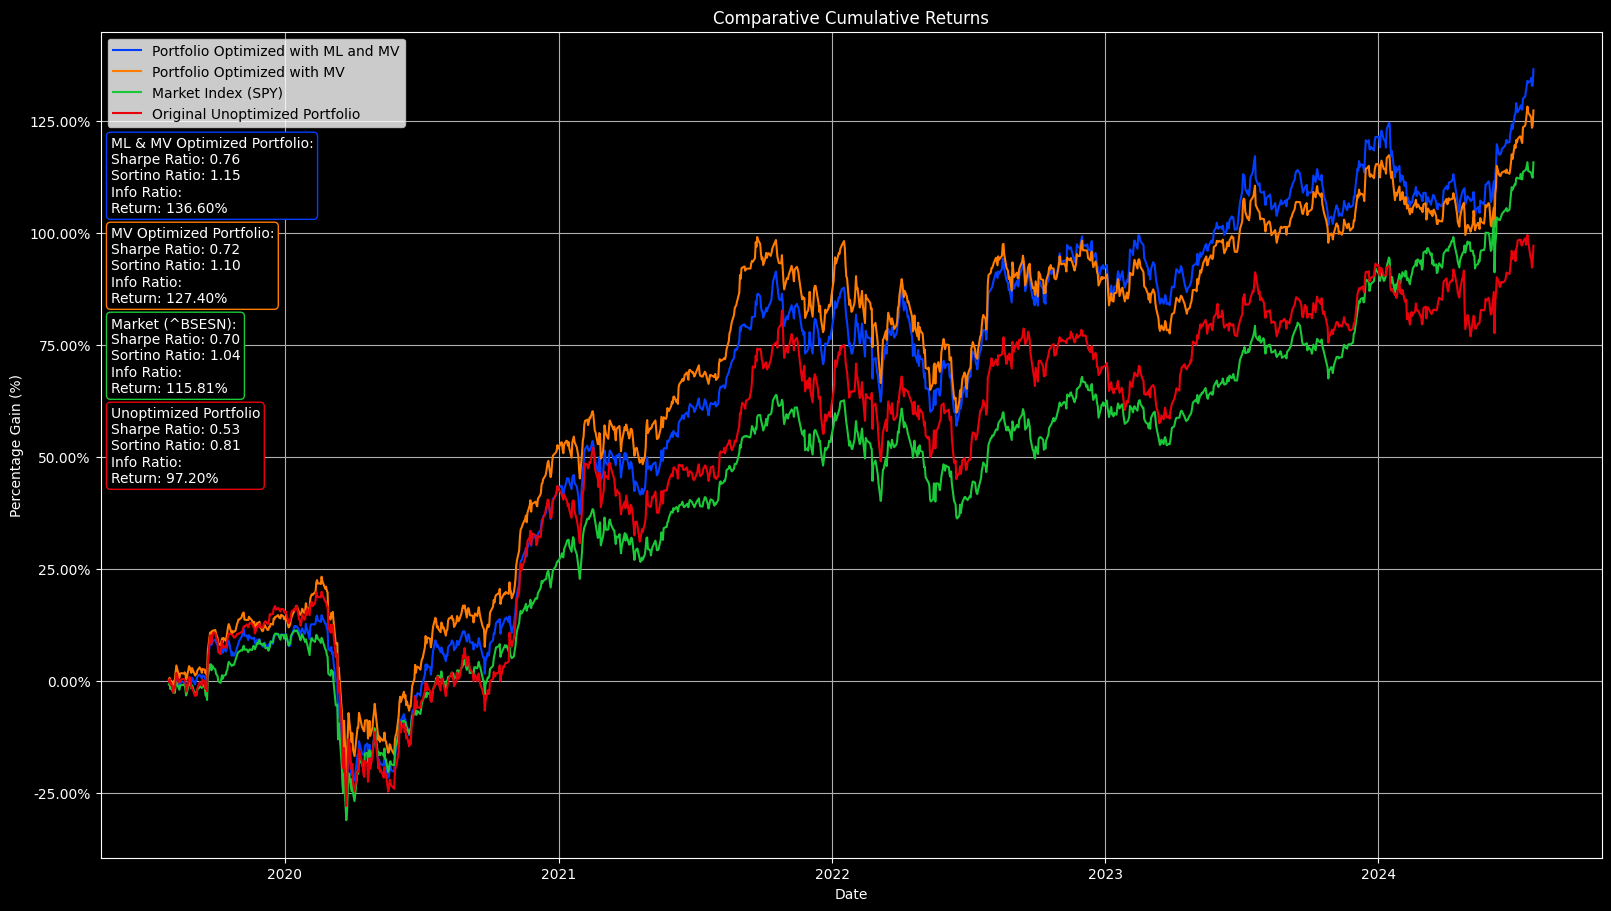

In [11]:
import mean_variance_optimization as mv
import machine_learning_strategies as mls
import black_litterman_model as bl
import portfolio_statistics as ps
import factor_analysis as fa   # For future use
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns



# Define current user portfolio
portfolio = {
    'RELIANCE.NS': 800.0,  # Reliance Industries Ltd.
    'TCS.NS': 100.0,       # Tata Consultancy Services Ltd.
    'HDFCBANK.NS': 130.0,  # HDFC Bank Ltd.
    'INFY.NS': 400.0,      # Infosys Ltd.
    'HINDUNILVR.NS': 100.0, # Hindustan Unilever Ltd.
    'ITC.NS': 170.0,        # ITC Ltd.
    'KOTAKBANK.NS': 1600.0,  # Kotak Mahindra Bank Ltd.
    'ICICIBANK.NS': 180.0,  # ICICI Bank Ltd.
    'BAJFINANCE.NS': 190.0, # Bajaj Finance Ltd.
    'LT.NS': 190.0          # Larsen & Toubro Ltd.
}


# Define market representation
market_representation = ['^BSESN']

# Define a dictionary for storing weights of portfolios
portfolio_weights = {}

# Define dates for training and backtesting
training_start_date = '2013-07-29'
training_end_date = '2019-07-29'
backtesting_start_date = training_end_date
backtesting_end_date = '2024-07-29'
risk_free_rate = 0.04

# Define risk sensitivity for Mean-Variance Optimization
max_volatility = 0.225

# Define minimum and maximum asset weights for Mean-Variance Optimization
min_weight = .01
max_weight = .25

# Perform Mean-Variance Optimization
tickers, weights = mv.calculate_weights(portfolio)
optimized_weights_mv = mv.mean_variance_optimization(tickers, training_start_date, training_end_date, max_volatility, min_weight=min_weight, max_weight=max_weight)

# Begin ML Training on stock ticker data for Black Litterman Model
investor_views = {}
view_confidences = {}

for ticker in tickers:
    investor_views[ticker], view_confidences[ticker] = mls.generate_investor_views(ticker, training_start_date, training_end_date)
print(investor_views)
market_caps = bl.get_market_caps(tickers)
# print(market_caps)
index_data = mv.download_stock_data(market_representation, training_start_date, training_end_date)
# print(index_data)
index_return = (index_data['Adj Close'].iloc[-1] / index_data['Adj Close'].iloc[0]) - 1

# Calculate market returns for each asset
market_returns = bl.get_market_returns(market_caps, index_return)

historical_data = mv.download_stock_data(tickers, training_start_date, training_end_date)
predicted_returns = bl.black_litterman_adjustment(market_returns, investor_views, view_confidences, historical_data)
# print(historical_data)

# Map adjusted returns to tickers
predicted_returns = dict(zip(tickers, predicted_returns))

# Convert adjusted returns to the format expected by the optimization function
adjusted_returns_vector = np.array([predicted_returns[ticker] for ticker in tickers])

# Perform mean-variance optimization with generated predicted returns
optimized_weights_ml_mv = mv.mean_variance_optimization(tickers, training_start_date, training_end_date, max_volatility, adjusted_returns_vector, min_weight, max_weight)

# Download market data for backtesting and calculate performance of each asset
historical_data_backtest = mv.download_stock_data(tickers, backtesting_start_date, backtesting_end_date)
print(historical_data_backtest)
daily_returns_backtest = historical_data_backtest['Adj Close'].pct_change()

# Calculate the cumulative performance of the machine learning mean variance optimized portfolio
portfolio_returns_ml_mv = daily_returns_backtest.dot(optimized_weights_ml_mv)
cumulative_returns_ml_mv = (1 + portfolio_returns_ml_mv).cumprod()

# print(portfolio_returns_ml_mv)
# Calculate cumulative returns for the first mean variance optimized portfolio
portfolio_returns_mv = daily_returns_backtest.dot(optimized_weights_mv)
cumulative_returns_mv = (1 + portfolio_returns_mv).cumprod()

# Download and calculate market index cumulative returns
market_data = mv.download_stock_data(market_representation, backtesting_start_date, backtesting_end_date)['Adj Close']
market_returns = market_data.pct_change()
cumulative_market_returns = (1 + market_returns).cumprod()

# Calculate cumulative returns for the unoptimized original portfolio
portfolio_returns_unoptimized = daily_returns_backtest.dot(weights)
cumulative_returns_unoptimized = (1 + portfolio_returns_unoptimized).cumprod()

# Convert weights to percentages with 2 decimal places for formatting
weights_pct = [f'{weight * 100:.2f}%' for weight in weights]
optimized_weights_pct = [f'{weight * 100:.2f}%' for weight in optimized_weights_mv]
optimized_weights_with_adjusted_returns_pct = [f'{weight * 100:.2f}%' for weight in optimized_weights_ml_mv]

# Create a DataFrame and output it to show comparison between portfolio weights
portfolio_comparison = pd.DataFrame({'Original': weights_pct,'MV Optimization': optimized_weights_pct, 'ML MV Optimization': optimized_weights_with_adjusted_returns_pct}, index=tickers)
print(portfolio_comparison)

# Calculate statistics for ML MV optimized portfolio
sharpe_ratio_ml_mv = ps.sharpe_ratio(portfolio_returns_ml_mv, risk_free_rate)
sortino_ratio_ml_mv = ps.sortino_ratio(portfolio_returns_ml_mv, risk_free_rate)
# info_ratio_ml_mv = ps.information_ratio(portfolio_returns_ml_mv, market_returns)

# Calculate statistics for MV optimized portfolio
sharpe_ratio_mv = ps.sharpe_ratio(portfolio_returns_mv, risk_free_rate)
sortino_ratio_mv = ps.sortino_ratio(portfolio_returns_mv, risk_free_rate)
# info_ratio_mv = ps.information_ratio(portfolio_returns_mv, market_returns)

# Calculate statistics for original unoptimized portfolio
sharpe_ratio_unoptimized = ps.sharpe_ratio(portfolio_returns_unoptimized, risk_free_rate)
sortino_ratio_unoptimized = ps.sortino_ratio(portfolio_returns_unoptimized, risk_free_rate)
# info_ratio_unoptimized = ps.information_ratio(portfolio_returns_unoptimized, market_returns)

# Calculate statistics for the market representation
sharpe_ratio_market = ps.sharpe_ratio(market_returns, risk_free_rate)
sortino_ratio_market = ps.sortino_ratio(market_returns, risk_free_rate)
# info_ratio_market = ps.information_ratio(market_returns, market_returns)

# Basic Plot Setup
plt.figure(figsize=(16, 9), constrained_layout=True)
ax = plt.gca()

sns.set_palette("bright")  # You can choose any palette like "deep", "muted", "bright", etc.
colors = sns.color_palette()

# Set plot aesthetics for readability
plt.gcf().set_facecolor('black')
ax.set_facecolor('black')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2f}%'.format(y)))

# ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{100 * y:.2f}%'))
for spine in ax.spines.values():
    spine.set_edgecolor('white')
print(cumulative_market_returns, cumulative_returns_ml_mv,cumulative_returns_mv)
# Convert cumulative returns to percentage gain
cumulative_returns_ml_mv_percent = (cumulative_returns_ml_mv - 1) * 100
cumulative_returns_mv_percent = (cumulative_returns_mv - 1) * 100
cumulative_returns_unoptimized_percent = (cumulative_returns_unoptimized - 1) * 100
cumulative_market_returns_percent = (cumulative_market_returns - 1) * 100

final_returns_ml_mv = cumulative_returns_ml_mv_percent[-1]
final_returns_mv = cumulative_returns_mv_percent[-1]
final_returns_unoptimized = cumulative_returns_unoptimized_percent[-1]
final_returns_market = cumulative_market_returns_percent[-1]

# Plot lines representing percentage gain returns
plt.plot(cumulative_returns_ml_mv_percent, label='Portfolio Optimized with ML and MV', color=colors[0])
plt.plot(cumulative_returns_mv_percent, label='Portfolio Optimized with MV', color=colors[1])
plt.plot(cumulative_market_returns_percent, label='Market Index (SPY)', color=colors[2])
plt.plot(cumulative_returns_unoptimized_percent, label='Original Unoptimized Portfolio', color=colors[3])

# Generate box for ML MV Optimized Portfolio
stats_text_ml_mv = f"ML & MV Optimized Portfolio:\nSharpe Ratio: {sharpe_ratio_ml_mv:.2f}\nSortino Ratio: {sortino_ratio_ml_mv:.2f}\nInfo Ratio: \nReturn: {final_returns_ml_mv:.2f}%"
plt.text(x=0.0655, y=0.77, s=stats_text_ml_mv, transform=plt.gcf().transFigure, fontsize=10, color='white', bbox=dict(boxstyle="round,pad=0.3", edgecolor=colors[0], facecolor='black'))

# Generate box for MV Optimized Portfolio
stats_text_mv = f"MV Optimized Portfolio:\nSharpe Ratio: {sharpe_ratio_mv:.2f}\nSortino Ratio: {sortino_ratio_mv:.2f}\nInfo Ratio:\nReturn: {final_returns_mv:.2f}%"
plt.text(x=0.0655, y=0.67, s=stats_text_mv, transform=plt.gcf().transFigure, fontsize=10, color='white', bbox=dict(boxstyle="round,pad=0.3", edgecolor=colors[1], facecolor='black'))

# Generate box for Unoptimized Portfolio
stats_text_unoptimized = f"Market ({market_representation[0]}):\nSharpe Ratio: {sharpe_ratio_market:.2f}\nSortino Ratio: {sortino_ratio_market:.2f}\nInfo Ratio: \nReturn: {final_returns_market:.2f}%"
plt.text(x=0.0655, y=0.57, s=stats_text_unoptimized, transform=plt.gcf().transFigure, fontsize=10, color='white', bbox=dict(boxstyle="round,pad=0.3", edgecolor=colors[2], facecolor='black'))

# Generate box for market
stats_text_market = f"Unoptimized Portfolio\nSharpe Ratio: {sharpe_ratio_unoptimized:.2f}\nSortino Ratio: {sortino_ratio_unoptimized:.2f}\nInfo Ratio:\nReturn: {final_returns_unoptimized:.2f}%"
plt.text(x=0.0655, y=0.47, s=stats_text_market, transform=plt.gcf().transFigure, fontsize=10, color='white', bbox=dict(boxstyle="round,pad=0.3", edgecolor=colors[3], facecolor='black'))


plt.title('Comparative Cumulative Returns', color='white')
plt.xlabel('Date')
plt.ylabel('Percentage Gain (%)')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [ ]:
# SAVE PLOT